## Boundstate code

In [29]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=0, which="LM", return_eigenvectors=False
                )
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)
    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
            candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
            candidates.append(candidate)
    print('candidates')
    print(candidates)
    
    eigenvalue_temp = []
    for energy in energies:
        eigenvalue_temp.append(min_eigenvalue(energy))
    print(eigenvalue_temp)
    plt.plot(energies, eigenvalue_temp)
    plt.xlabel(r'$E$')
    plt.ylabel(r'$f(E)$')
    plt.axhline(0, color='k', linestyle=':')
    #plt.xlim(-0.4, -0.35)
    #plt.ylim(-0.02, 0.02)

    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )
    #print('lhs')
    #print(lhs)
    #print('T')
    #print(T)

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=0, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            print('k')
            print(k)
            print('vals')
            print(vals)
            print('zeros')
            print(zeros)
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
                print('found all zeros')
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        print('route 1')
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        print('bound states')
        print(bound_states)
        print('returned')
        print(np.asarray(zero_vecs @ bound_states))
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        #print('svd_v')
        #print(svd_v)
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]
        #print('u_out')
        #print(u_out)
        #print('ulinv_out')
        #print(ulinv_out)

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


In [26]:
h_hop = systf.leads[0].inter_cell_hopping()
n, m = h_hop.shape
print(n, m)
print(spi.linalg.inv(h_hop))

ham = systf.leads[0].cell_hamiltonian()
print(ham)
hop = np.empty_like(ham, dtype=h_hop.dtype)
hop[:, :m] = h_hop
hop[:, m:] = 0
print(h_hop)
print(hop)
print(np.allclose(h_hop, hop))


4 4
[[-0.8+0.j   0. +0.4j  0. +0.j   0. -0.j ]
 [ 0. +0.4j -0.8+0.j   0. +0.j   0. -0.j ]
 [ 0. +0.j   0. +0.j   0.8+0.j   0. -0.4j]
 [ 0. +0.j   0. +0.j   0. -0.4j  0.8+0.j ]]
[[ 3.5+0.j  0. +0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  1.5+0.j  0. +0.j  0.5+0.j]
 [ 0.5+0.j  0. +0.j -1.5+0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j  0. +0.j -3.5+0.j]]
[[-1.-0.j   0.-0.5j  0.-0.j   0.-0.j ]
 [ 0.-0.5j -1.-0.j   0.-0.j   0.-0.j ]
 [ 0.-0.j   0.-0.j   1.-0.j   0.+0.5j]
 [ 0.-0.j   0.-0.j   0.+0.5j  1.-0.j ]]
[[-1.-0.j   0.-0.5j  0.-0.j   0.-0.j ]
 [ 0.-0.5j -1.-0.j   0.-0.j   0.-0.j ]
 [ 0.-0.j   0.-0.j   1.-0.j   0.+0.5j]
 [ 0.-0.j   0.-0.j   0.+0.5j  1.-0.j ]]
True


lead hamiltonian submatrix #####################
[[ 3.5+0.j   0. +0.j   0.5+0.j   0. +0.j  -1. -0.j   0. -0.5j  0. -0.j
   0. -0.j ]
 [ 0. +0.j   1.5+0.j   0. +0.j   0.5+0.j   0. -0.5j -1. -0.j   0. -0.j
   0. -0.j ]
 [ 0.5+0.j   0. +0.j  -1.5+0.j   0. +0.j   0. -0.j   0. -0.j   1. -0.j
   0. +0.5j]
 [ 0. +0.j   0.5+0.j   0. +0.j  -3.5+0.j   0. -0.j   0. -0.j   0. +0.5j
   1. -0.j ]
 [-1. +0.j   0. +0.5j  0. +0.j   0. +0.j   3.5+0.j   0. +0.j   0.5+0.j
   0. +0.j ]
 [ 0. +0.5j -1. +0.j   0. +0.j   0. +0.j   0. +0.j   1.5+0.j   0. +0.j
   0.5+0.j ]
 [ 0. +0.j   0. +0.j   1. +0.j   0. -0.5j  0.5+0.j   0. +0.j  -1.5+0.j
   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. -0.5j  1. +0.j   0. +0.j   0.5+0.j   0. +0.j
  -3.5+0.j ]]
svd_v###################################
[[1.49534878 0.         0.         0.        ]
 [0.         1.49534878 0.         0.        ]
 [0.         0.         1.49534878 0.        ]
 [0.         0.         0.         1.49534878]]
V!!!!!!!!
[[-1.-0.j   0.-0.5j  0.-0.j   0.-0.j 

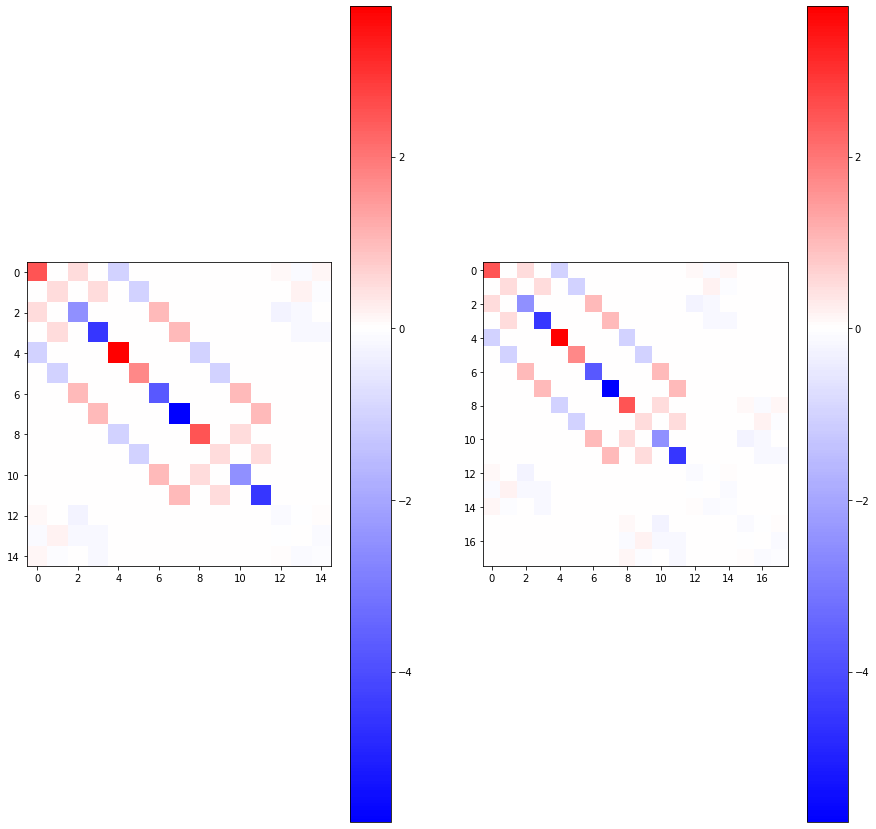

In [46]:
import scipy as spi

systf = make_system_ex()
lhs, norb = systf.hamiltonian_submatrix(return_norb=True
    )[:2]
offsets = np.empty(norb.shape[0] + 1, int)
offsets[0] = 0
offsets[1:] = np.cumsum(norb)
scattering_region_norbs = offsets[-1]

energy = 0.383106779261225
energy = 1

lhs = lhs - energy * sp.identity(lhs.shape[0])

phi_e = []
svd_vs = []
transfs = []

norm1 = colors.DivergingNorm(vcenter=0)
norm2 = colors.DivergingNorm(vcenter=0)

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,15))
axes = [ax1, ax2]
norms = [norm1, norm2]

for leadnum, interface in enumerate(systf.lead_interfaces):
    lead = systf.leads[leadnum]
    print('lead hamiltonian submatrix #####################')
    print(lead.hamiltonian_submatrix())
    _, stab = lead.modes(energy)
    print(stab)
    svd_v = stab.sqrt_hop
    print('svd_v###################################')
    print(svd_v)
    print('V!!!!!!!!')
    trial_v = lead.inter_cell_hopping()
    print(trial_v)
    print('V sp.svd@@@@@@@@@@@')
    print(spi.linalg.svd(trial_v))
    print(spi.linalg.eig(trial_v, left=True, right=True))
    # Evanescent modes (schur vectors) are stored after
    # the 2*nmodes propagating (in/out) modes
    print('stab.vecs')
    print(stab.vecs)
    evan_vecs = slice(2 * stab.nmodes, None)
    u_out = stab.vecs[:, evan_vecs]
    print('u_out ###################################')
    print(u_out)
    ulinv_out = stab.vecslmbdainv[:, evan_vecs]
    print('ulinv_out ###################################')
    print(ulinv_out)
    print('u_out/ulinv_out#############################')
    print(stab.vecs/stab.vecslmbdainv)

    # Construct a matrix of 1's that translates the
    # inter-cell hopping to a proper hopping
    # from the system to the lead.
    iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]
    print(iface_orbs)

    n_lead_orbs = svd_v.shape[0]
    print(n_lead_orbs)
    if n_lead_orbs != len(iface_orbs):
        msg = (
            "Lead {0} has hopping with dimensions "
            "incompatible with its interface dimension."
        )
        raise ValueError(msg.format(leadnum))

    coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
    print(coords)
    transf = sp.csc_matrix(
        (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
    )

    phi_e.append(ulinv_out)
    svd_vs.append(svd_v)
    # We are saving these for use in '_validation_operator', where we
    # expect each projector to project *from the scattering region only*,
    # hence the slice up to 'scattering_region_norbs'
    transfs.append(transf[:, :scattering_region_norbs])

    A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
    print('A before####')
    print(A)
    A = sp.csc_matrix(A)
    B = sp.csc_matrix(B)
    C = sp.csc_matrix(C)
    lhs = sp.bmat([[lhs, A], [B, C]])
    
    print('A######')
    print(A.toarray())
    print('B#####')
    print(B)
    print('C#####')
    print(C)
    
    im1 = axes[leadnum].imshow(np.real(lhs.toarray()), cmap='bwr', interpolation='none', norm=norms[leadnum])
    fig.colorbar(im1, ax=axes[leadnum])



## My code

In [3]:
import kwant
import tinyarray
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

a = 1 # angstroms

norbs = 4 # N_t = 4

lat = kwant.lattice.chain(a, norbs=4)

In [4]:
## Explicit S-N-S (equivalent to explicit S-N as evidenced by Ryan's code)

def make_system_ex(mu=0.5,
                t=-1., B=1., delta=0.5, alpha_so=0.5, V_N=1.25, phi=0, L=3):
    lat = kwant.lattice.chain(norbs=4)
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    #### Define the scattering region. ####
    syst[(lat(0))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    syst[(lat(x) for x in range(1, L-1))] = (mu-2.*t+V_N)*tau_z + B*sigma_z
    syst[(lat(L-1))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    
    syst[(lat(0), lat(1))] = np.matmul(sp.linalg.expm(phi*1j*tau_z), t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x))
    syst[(lat(1), lat(2))] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-a])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    lead0[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    sym_right = kwant.TranslationalSymmetry([a])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L))] =  (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    lead1[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [5]:
## Explicit S-N-S (equivalent to explicit S-N as evidenced by Ryan's code)

def make_system_ryan(mu=0.5,
                t=-1., B=1., delta=0.5, alpha_so=0.5, V_N=1.25, phi=0, L=3):
    lat = kwant.lattice.chain(norbs=4)
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    #### Define the scattering region. ####
    syst[(lat(0))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    syst[(lat(x) for x in range(1, L-1))] = (mu-2.*t+V_N)*tau_z + B*sigma_z
    #syst[(lat(L-1))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    
    syst[(lat(0), lat(1))] = np.matmul(sp.linalg.expm(phi*1j*tau_z), t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x))
    #syst[(lat(1), lat(2))] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-a])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    lead0[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    sym_right = kwant.TranslationalSymmetry([a])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L))] =  (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    lead1[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [6]:
## Explicit S-N-S (equivalent to explicit S-N as evidenced by Ryan's code)

def make_system_Lsites(mu=0.5,
                t=-1., B=1., delta=0.5, alpha_so=0.5, V_N=1.25, phi=0, L=4):
    lat = kwant.lattice.chain(norbs=4)
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    #### Define the scattering region. ####
    syst[(lat(0))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    syst[(lat(1))] = (mu-2.*t+V_N)*tau_z + B*sigma_z
    syst[(lat(x) for x in range(2, L))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    
    syst[(lat(0), lat(1))] = np.matmul(sp.linalg.expm(phi*1j*tau_z), t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x))
    for x in range(2, L):
        syst[(lat(x-1), lat(x))] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-a])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    lead0[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    sym_right = kwant.TranslationalSymmetry([a])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L))] =  (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    lead1[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

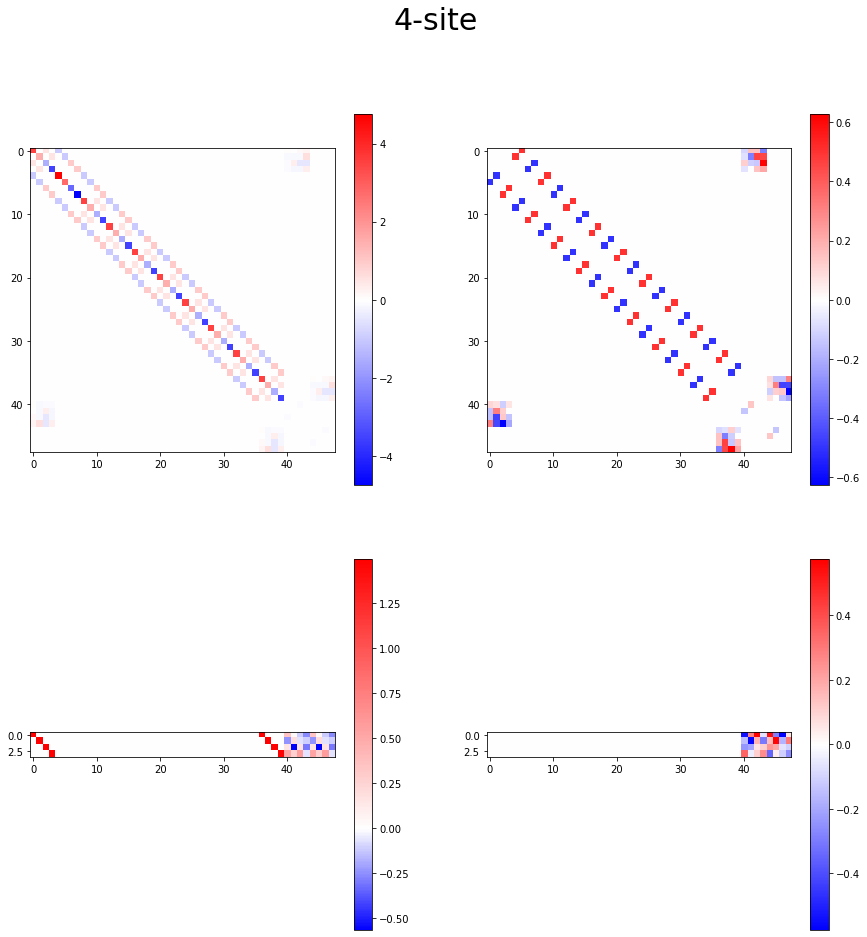

In [415]:
systf = make_system_Lsites(L=10)
lhs, T = make_linsys(systf, return_validation=True)
#print('lhs')
#print(lhs.toarray())
#print('T')
#print(T.toarray())


norm1 = colors.DivergingNorm(vcenter=0)
norm2 = colors.DivergingNorm(vcenter=0)
norm3 = colors.DivergingNorm(vcenter=0)
norm4 = colors.DivergingNorm(vcenter=0)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('4-site', fontsize=30)
im1 = ax1.imshow(np.real(lhs.toarray()), cmap='bwr', interpolation='none', norm=norm1)
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(np.imag(lhs.toarray()), cmap='bwr', interpolation='none', norm=norm2)
fig.colorbar(im2, ax=ax2)
im3 = ax3.imshow(np.real(T.toarray()), cmap='bwr', interpolation='none', norm=norm3)
fig.colorbar(im3, ax=ax3)
im4 = ax4.imshow(np.imag(T.toarray()), cmap='bwr', interpolation='none', norm=norm4)
fig.colorbar(im4, ax=ax4)

plt.savefig('4site_hamil_T', dpi=300)


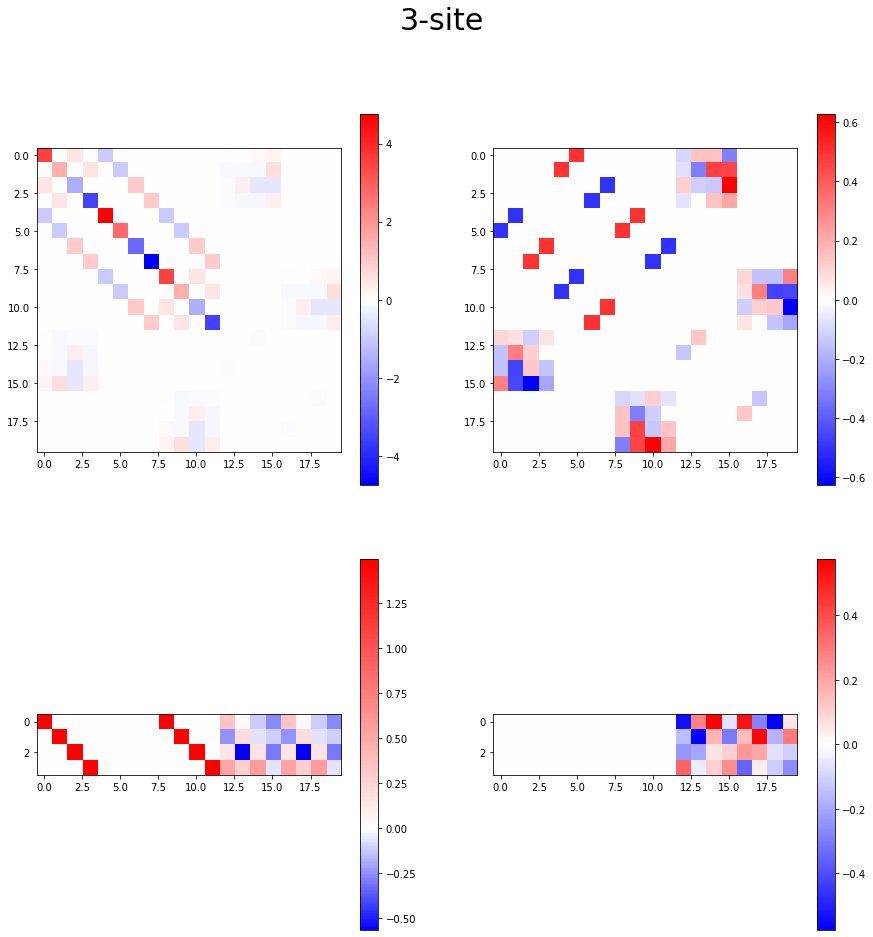

In [507]:
systf = make_system_ex()
lhs, T = make_linsys(systf, energy=0., return_validation=True)
#print('lhs')
#print(lhs.toarray())
#print('T')
#print(T.toarray())


norm1 = colors.DivergingNorm(vcenter=0)
norm2 = colors.DivergingNorm(vcenter=0)
norm3 = colors.DivergingNorm(vcenter=0)
norm4 = colors.DivergingNorm(vcenter=0)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('3-site', fontsize=30)
im1 = ax1.imshow(np.real(lhs.toarray()), cmap='bwr', interpolation='none', norm=norm1)
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(np.imag(lhs.toarray()), cmap='bwr', interpolation='none', norm=norm2)
fig.colorbar(im2, ax=ax2)
im3 = ax3.imshow(np.real(T.toarray()), cmap='bwr', interpolation='none', norm=norm3)
fig.colorbar(im3, ax=ax3)
im4 = ax4.imshow(np.imag(T.toarray()), cmap='bwr', interpolation='none', norm=norm4)
fig.colorbar(im4, ax=ax4)

plt.savefig('Chi_hamil_T', dpi=300)


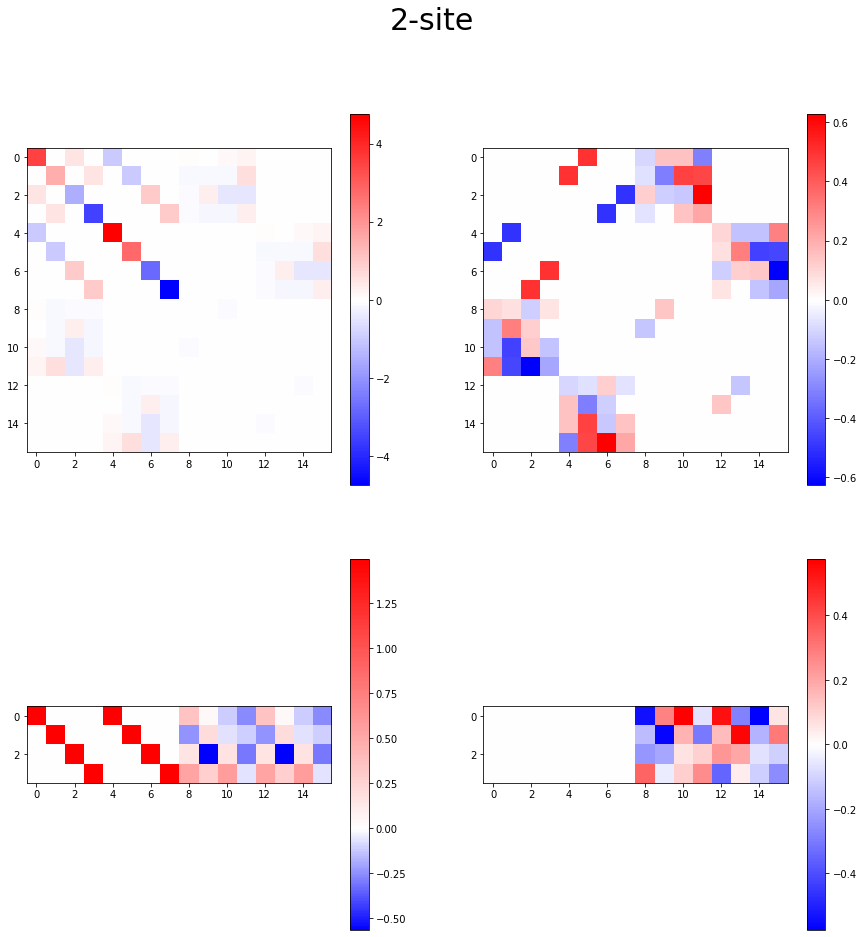

In [413]:
systf = make_system_ryan()
lhs, T = make_linsys(systf, return_validation=True)
#print('lhs')
#print(lhs.toarray())
#print('T')
#print(T.toarray())


norm1 = colors.DivergingNorm(vcenter=0)
norm2 = colors.DivergingNorm(vcenter=0)
norm3 = colors.DivergingNorm(vcenter=0)
norm4 = colors.DivergingNorm(vcenter=0)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('2-site', fontsize=30)
im1 = ax1.imshow(np.real(lhs.toarray()), cmap='bwr', interpolation='none', norm=norm1)
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(np.imag(lhs.toarray()), cmap='bwr', interpolation='none', norm=norm2)
fig.colorbar(im2, ax=ax2)
im3 = ax3.imshow(np.real(T.toarray()), cmap='bwr', interpolation='none', norm=norm3)
fig.colorbar(im3, ax=ax3)
im4 = ax4.imshow(np.imag(T.toarray()), cmap='bwr', interpolation='none', norm=norm4)
fig.colorbar(im4, ax=ax4)

plt.savefig('Ryan_hamil_T', dpi=300)

candidates
[-0.45019783738231367, -0.3831067792612256, -1.1772335786875034e-12, 0.383106779261225, 0.4501978373823138]
[-0.06691265431864238, -0.0701236109690598, -0.07379719084807483, -0.07796019014265707, -0.08258044359601885, 0.08686273439742945, 0.0820017902985247, 0.07734646889335278, 0.07296880836869755, 0.068891740051294, 0.06510711534911952, 0.06159097937542257, -0.017171753405438934, -0.03338814168918626, -0.04502376610202329, -0.0547094526199312, -0.0631814874222679, -0.0707787270884856, -0.07769317823198811, -0.084047550146965, -0.08992675791713496, -0.09539299761053296, -0.1004938121491782, -0.10526677370995526, -0.10974237707808224, -0.11394591803194987, -0.11789876265390921, -0.1216192339820069, -0.1251232488962647, -0.1284247866442371, -0.13153624071985148, -0.1344686879988212, -0.13723209797935343, -0.1398354979090364, -0.14228710494101804, -0.14459443334875954, -0.14676438269524958, -0.148803311363726, -0.15071709880015824, -0.15251119905464364, -0.15419068764719368, -

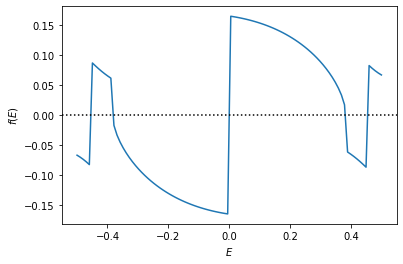

In [37]:
systf = make_system_ex(B=0.324)
energies, wavefunctions = find_boundstates(systf, -0.5, 0.5, rtol=1e-2)
print(energies)

In [428]:
def B_scan(phiv=0., V_Nv=1.25, tv=-1., Lv=3):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 1, 21):
        systf = make_system_Lsites(B=i, L=Lv, phi=phiv, V_N=V_Nv, t=tv)
        #systf = syst.finalized()
        energies, wavefunctions = find_boundstates(systf, -0.6, 0.6, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
    return energy_arrays, wavefunc_arrays

candidates
[-0.5995248970747815, -0.5413729196678131, -0.4999999999994564, -0.48286986421626593, -0.45867704918789837, -0.21123144228524682, -1.1749335850252392e-12, 0.21123144228524676, 0.4586770491878985, 0.48286986421626593, 0.5000000000007437, 0.5413729196678131, 0.5995248970747815]
[0.00047510292521845353, -0.009608930688226814, -0.019692964301672312, -0.02977699791511796, -0.039861031528563066, -0.049945065142008596, 0.05627485606074581, 0.046190822447300384, 0.03610678883385504, 0.026022755220409723, -0.0061268789329352695, -0.0287844060756636, 0.03268286478554311, 0.015827153326414923, 0.00021742580703617233, -0.014216628522732033, -0.027738422580204862, -0.04056134426914033, -0.052842223182250826, -0.06469511321365495, -0.07620336739004756, -0.08742828909055958, -0.09841510162305059, -0.10919704307073812, -0.11979817239276984, -0.130235279407535, -0.14051915532121256, -0.15065538896812128, -0.16064479241518906, -0.1704835179425279, -0.18016290089958675, -0.1896690477967759, -0

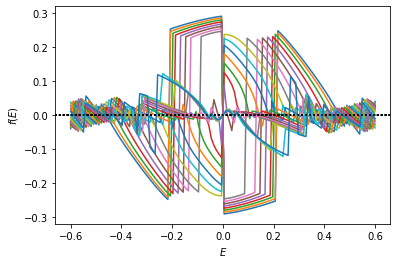

In [432]:
Be_array, Bpsi_array = B_scan(tv=0.7, Lv=10)
print(Be_array)

Text(0.5, 1.0, '$\\phi=0\\pi, \\Delta=0.5, t=-1, V_N=1.25, \\mu=0.5, \\alpha_{so}=0.5, L=10$')

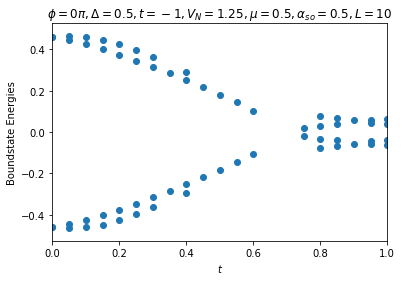

In [433]:
Bex = []
Bey = []
for i in range(len(Be_array)):
    for j in range(len(Be_array[i])):
        Bex.append(i/20.)
        Bey.append(Be_array[i][j])
plt.scatter(Bex, Bey)
#plt.axhline(0.2, color='k', linestyle=':')
#plt.axhline(-0.2, color='k', linestyle=':')
plt.xlim(0, 1)
plt.xlabel(r'$t$')
plt.ylabel('Boundstate Energies')
plt.title(r'$\phi=0\pi, \Delta=0.5, t=-1, V_N=1.25, \mu=0.5, \alpha_{so}=0.5, L=10$')

candidates
[-0.44089997384618346, -0.3571067811856667, -1.1774868347961912e-12, 0.3571067811856667, 0.44089997384618357]
[-0.0679886109213806, -0.07107116964041696, -0.07452626039901997, -0.07839056026920363, -0.0826660839289676, -0.08730631125608578, 0.09081501719403944, 0.08641843626123995, 0.08211983576848009, 0.07798508180387803, 0.07404655807686929, 0.07031244453623656, 0.06677615981295275, 0.06342343201697866, 0.06023682036889832, -0.028780260109684687, -0.04211654869265091, -0.0525541025077423, -0.06145987791667529, -0.06934010011625544, -0.076452897946796, -0.08295291822447953, -0.08894254306832419, -0.09449436765914046, -0.09966251930409428, -0.10448893754544908, -0.1090071202314737, -0.11324448747355587, -0.11722394222823708, -0.12096493931143862, -0.12448424064925459, -0.12779646305161732, -0.13091448462981972, -0.1338497524274498, -0.13661251950469547, -0.13921203071349306, -0.14165667058478648, -0.14395408289725917, -0.1461112688885041, -0.1481346692661717, -0.150030233903

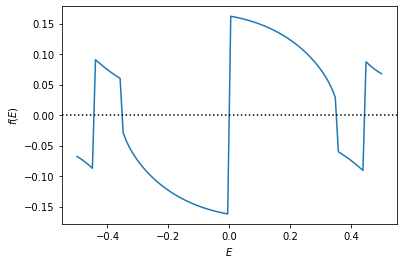

In [336]:
systf = make_system_ex(B=0.35)
energies, wavefunctions = find_boundstates(systf, -0.5, 0.5, rtol=1e-2)
print(energies)

In [356]:
[[-1.24623831e-01+2.34338289e-02j]
 [-5.27514001e-02-2.80538560e-01j]
 [-9.79986862e-02+1.84274471e-02j]
 [-1.81833664e-02-9.67017418e-02j]
 [ 2.67897796e-09+1.42471999e-08j]
 [-4.23749542e-02-2.25356252e-01j]
 [ 2.06906046e-08+1.10035684e-07j]
 [-1.22931947e-02-6.53770213e-02j]
 [ 1.24623880e-01-2.34335655e-02j]
 [-5.27509785e-02-2.80538639e-01j]
 [ 9.79987677e-02-1.84270136e-02j]
 [-1.81833372e-02-9.67017473e-02j]
 [-3.24289744e-01+1.74986809e-01j]
 [ 1.74135649e-01+2.90507951e-01j]
 [-8.28798444e-02+5.08654475e-02j]
 [ 1.55677957e-01-2.64787664e-01j]
 [ 3.65700957e-01+4.52441271e-02j]
 [-5.67215958e-02+3.33917286e-01j]
 [ 9.56949302e-02+1.72870673e-02j]
 [-2.41223499e-01-1.90156138e-01j]]

TypeError: list indices must be integers or slices, not complex

In [360]:
systf = make_system_ex(B=0.325)
extract_boundstates(systf, 0.382106781186819816)


k
6
vals
[ 1.50680152e-04  1.32274954e-01 -1.70657759e-01 -1.96234156e-01
 -1.80570662e-01 -1.83705365e-01]
vecs
[[-9.56223750e-02+8.32862830e-02j  6.25700002e-02+2.72600053e-02j
  -7.75972093e-04+3.12081800e-02j  9.38080726e-02+4.66069346e-02j
   9.71755575e-03+7.81970003e-03j  6.88640551e-02+5.90619642e-02j]
 [-1.87484241e-01-2.15253927e-01j -9.84852070e-02+2.26052823e-01j
  -6.46668881e-02-1.60799195e-03j -6.44852424e-02+1.29789600e-01j
   4.58873595e-02-5.70623171e-02j  6.21578495e-03-7.25347568e-03j]
 [-7.51931606e-02+6.54927622e-02j  5.46770618e-02+2.38212123e-02j
   2.76772350e-04-1.11319366e-02j -1.72649216e-02-8.57752901e-03j
  -3.05004582e-02-2.45306543e-02j -4.51994496e-02-3.87642601e-02j]
 [-6.46258331e-02-7.41981359e-02j -2.45093542e-02+5.62561645e-02j
   4.53013888e-02+1.12646719e-03j -3.53857527e-03+7.12278704e-03j
  -3.15840828e-02+3.92733932e-02j -2.52946192e-02+2.94952042e-02j]
 [ 9.52141051e-09+1.09317140e-08j -2.83414102e-02-1.23475522e-02j
   1.44839899e-05-5.82503

array([], shape=(20, 0), dtype=complex128)

In [254]:
systf = make_system_ex(B=0.35)
extract_boundstates(systf, 0.3571067811865756)

k
6
vals
[ 0.00398499  0.13319842 -0.17072907 -0.19565186 -0.18339061 -0.18490215]
zeros
[False False False False False False]
found all zeros


array([], shape=(20, 0), dtype=float64)

candidates
[-0.4585998474309077, -0.40682884603147973, 1.1771181166322882e-12, 0.40682884603148084, 0.4585998474309078]
[-0.06494715367188104, -0.06828516452888414, -0.07219082481923465, -0.07666818363530435, -0.0816328025180315, 0.07723720572337336, 0.07212787252054549, 0.067447142832977, 0.0632033440342324, 0.05936364999967215, -0.02048085426636653, -0.034592818163368094, -0.045605125831106146, -0.05499896001737778, -0.06331215609965264, -0.07081750733877448, -0.07767825577986932, -0.08400252026852188, -0.08986704506112025, -0.09532912415282241, -0.10043320892568866, -0.10521484865393883, -0.10970317814090963, -0.11392256122963987, -0.1178937177273532, -0.1216345203834474, -0.1251605734501737, -0.12848564219873007, -0.1316219780485155, -0.13458056892571707, -0.13737133501165613, -0.14000328392643835, -0.14248463533938754, -0.14482292225051369, -0.14702507428914424, -0.14909748704184894, -0.15104608046979565, -0.15287634878692122, -0.15459340366512592, -0.15620201225674332, -0.1577066

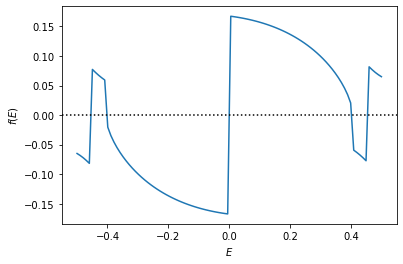

In [348]:
systf = make_system_ex(B=0.3)
energies, wavefunctions = find_boundstates(systf, -0.5, 0.5, rtol=1e-2)
print(energies)

candidates
[1.1801554884075766e-12]
[-0.20710678118654735, -0.21720779128755657, -0.22730880138856763, -0.23740981148957746, -0.24751082159058757, -0.25761183169159757, -0.26771284179260785, -0.2778138518936182, -0.287914861994628, -0.2980158720956383, -0.30811688219664807, -0.3182178922976587, -0.3283189023986685, -0.33841991249967884, -0.34852092260068857, -0.3586219327016989, -0.36872294280270895, -0.3788239529037194, -0.3889249630047291, -0.3990259731057386, -0.40912698320674906, -0.41922799330775956, -0.4293290034087695, -0.43943001350977906, -0.4495310236107895, -0.45963203371179945, -0.4697330438128099, -0.4798340539138197, -0.48993506401483006, -0.5000360741158397, -0.5101370842168504, -0.5202380943178605, -0.5303391044188698, -0.5404401145198807, -0.550541124620891, -0.5606421347219002, -0.5707431448229108, -0.5808441549239209, -0.5909451650249311, -0.6010461751259413, -0.6111471852269512, -0.6212481953279615, -0.6313492054289718, -0.6414502155299818, -0.6515512256309918, -0.6

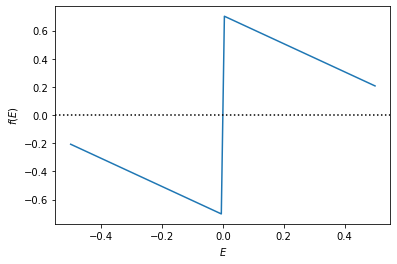

In [342]:
systf = make_system_ex(B=0., t=0., alpha_so=0.)
energies, wavefunctions = find_boundstates(systf, -0.5, 0.5, rtol=1e-2)
print(energies)

In [347]:
def trial_func(x):
    if x<0.:
        return -10000.
    else:
        return 10000.
    

scipy.optimize.brentq(trial_func, -1, 1)
print(trial_func(0))

10000.0


In [291]:
trial_array = [0.11898631984689163482634876, 120.182128498164918264966]
np.hstack(trial_array)

array([1.18986320e-01, 1.20182128e+02])